In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load Train data from our github repo
url_train = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20(1)/data_without_columns_train.csv'
dataDF_train = pd.read_csv(url_train)

# Load Train label data from our github repo
url_train_labels = 'https://raw.githubusercontent.com/tjayada/iANNwTF_Project/main/data/cleaned%20data%20(1)/data_without_columns_train_labels.csv'
dataDF_train_labels = pd.read_csv(url_train_labels)

In [3]:
# drop indices 
dataDF_train = dataDF_train.drop("Unnamed: 0", axis = 1)
dataDF_train_labels = dataDF_train_labels.drop("Unnamed: 0", axis = 1)

In [4]:
# split data into training and test
X_train, X_valid, y_train, y_valid = train_test_split(dataDF_train, dataDF_train_labels, test_size=0.25, random_state=1)

In [5]:
# create tf dataset out of the panda dataframes
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

X_valid = tf.data.Dataset.from_tensor_slices(X_valid)
y_valid = tf.data.Dataset.from_tensor_slices(y_valid)

In [6]:
# combine data and target labels
train_dataset = tf.data.Dataset.zip((X_train, y_train))
test_dataset = tf.data.Dataset.zip((X_valid, y_valid))

In [7]:
# shuffle, batch and prefetch data
train_dataset = train_dataset.shuffle(1000).batch(64).prefetch(64)
test_dataset = test_dataset.shuffle(1000).batch(64).prefetch(64)

In [8]:
# create linear regression model
class linear_regression_model(tf.keras.Model):

    def __init__(self):
        super(linear_regression_model, self).__init__()
        self.dense_layer = SimpleDense(1, activation = tf.keras.activations.linear)
        

    def call(self, inputs):
        out = self.dense_layer(inputs)
        return out

class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units, activation):
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs):
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [9]:
def train_step(model, input, target, loss_function, optimizer):
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.round(target, 0) == np.round(prediction, 0)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [10]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 100
learning_rate = 0.01

# Initialize the model.
model = linear_regression_model()
# Initialize the loss: mean squared error
mse_loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer: Adam with default parameters
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, mse_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, mse_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    interesting_epochs = np.arange(9,200,10)
    if epoch == 0 or epoch in interesting_epochs:
      rmse = np.sqrt(test_losses[-1])
      rmse = np.format_float_positional(rmse, 3)
      print(f'Epoch: {str(epoch+1)} has a RMSE of {rmse}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, mse_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, mse_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 1 has a RMSE of 80.103
Epoch: 10 has a RMSE of 44.962
Epoch: 20 has a RMSE of 42.564
Epoch: 30 has a RMSE of 41.068
Epoch: 40 has a RMSE of 39.589
Epoch: 50 has a RMSE of 39.166
Epoch: 60 has a RMSE of 38.346
Epoch: 70 has a RMSE of 38.090
Epoch: 80 has a RMSE of 37.576
Epoch: 90 has a RMSE of 37.600
Epoch: 100 has a RMSE of 37.676


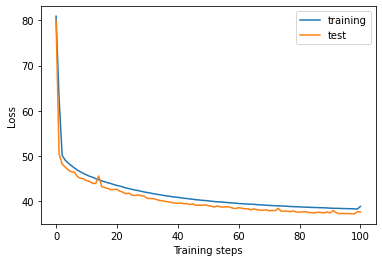

In [11]:
# Visualize loss for training and test data.
plt.figure()
line1, = plt.plot(np.sqrt(train_losses))
line2, = plt.plot(np.sqrt(test_losses))
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()